In [1]:
import pandas as pd
import numpy as np
import re
import os
import sys
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TOP_PATH = os.environ['PWD']

In [4]:
sys.path.append(TOP_PATH + '/config')
sys.path.append(TOP_PATH + '/src')

In [5]:
from trends import *
import etl
from regression import regression

In [63]:
test_date = '10-11-2018'
test_date_2 = '11-12-2018'

In [64]:
df_2017 = pd.read_csv(TOP_PATH + '/data/cleaned/2017_cleaned.csv')

In [65]:
df_2018_2019 = pd.read_csv(TOP_PATH + '/data/cleaned/2018-2019_cleaned.csv')

In [66]:
df_2014 = pd.read_csv(TOP_PATH + '/data/cleaned/2014_cleaned.csv')

In [67]:
df_2015 = pd.read_csv(TOP_PATH + '/data/cleaned/2015_cleaned.csv')

In [68]:
df_2016 = pd.read_csv(TOP_PATH + '/data/cleaned/2016_cleaned.csv')

In [69]:
df_2018_2019['subject_race'].unique()

array(['White', 'Hispanic/Latino/a', 'Black/African American',
       'Native American', 'Middle Eastern or South Asian', 'Asian',
       'Pacific Islander'], dtype=object)

In [70]:
#DACA example for regression
# [2017,7,5] to [2017,11,5]
start_date = pd.to_datetime('07-05-2017')
end_date = pd.to_datetime('11-05-2017')
event_date = pd.to_datetime('09-05-2017')
df_regr = df_2017.copy()
df_regr = df_regr[[start_date <= pd.to_datetime(x) and end_date >= pd.to_datetime(x) for x in df_regr['date_stop']]]

KeyboardInterrupt: 

In [ ]:
df_regr_hisp = df_regr.copy()

In [ ]:
df_regr_hisp['Hispanic'] = [1 if x == 'Hispanic/Latino/a' else 0 for x in df_regr_hisp['subject_race']]

In [ ]:
daca_df = pd.read_csv(TOP_PATH + '/data/raw/DACA.csv')

In [ ]:
daca_df.drop('Unnamed: 0', inplace = True, axis = 1)

In [ ]:
temp = df_regr_hisp[['date_stop', 'Hispanic']].groupby('date_stop').mean().reset_index()

In [ ]:
daca_df.reset_index()

In [ ]:
daca_df['value'] = [int(x) if x.isnumeric() else 0 for x in daca_df['value']]

In [ ]:
df = temp.merge(daca_df, left_on = 'date_stop', right_on = 'date')

In [ ]:
df = df.sort_values('value').reset_index(drop = True)

In [ ]:
reg = LinearRegression().fit(df['value'].values.reshape(-1,1), df['Hispanic'].values)

In [ ]:
df

In [35]:
reg.coef_

array([0.00051768])

In [36]:
reg.intercept_

0.29590542642929457

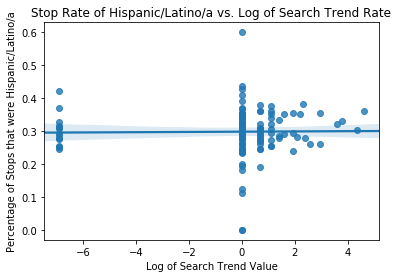

In [72]:
x = regression(('07-05-2017', '11-05-2017'), 'Hispanic/Latino/a', 'DACA', 'log')

In [57]:
x.coef_

array([0.00038649])

<class 'matplotlib.axes._subplots.AxesSubplot'>


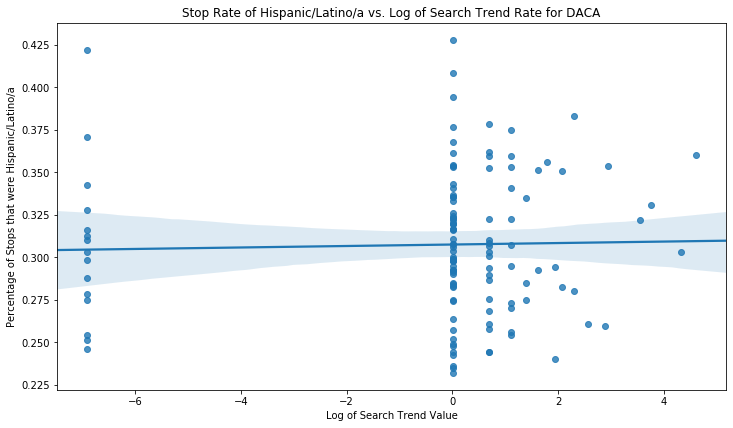

In [28]:
reg_daca = regression(('07-05-2017', '11-05-2017'), 'Hispanic/Latino/a', 'DACA', save_fig = True)
#eda_viz.month_race_count_viz(('07-05-2017', '11-05-2017'), 'DACA', save_fig = True)

<class 'matplotlib.axes._subplots.AxesSubplot'>


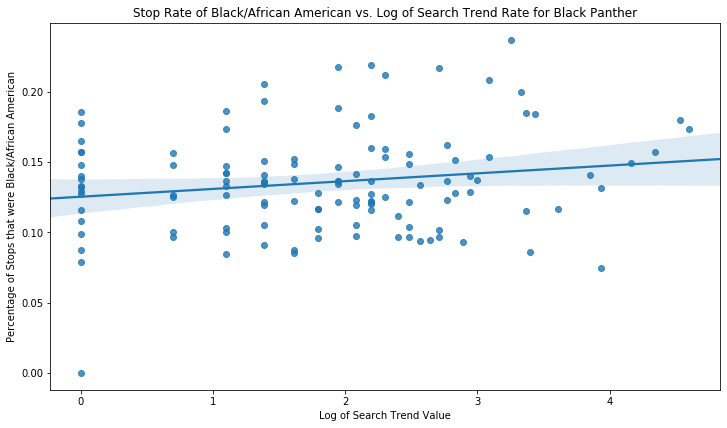

In [29]:
reg_blp = regression(('12-16-2017', '04-16-2018'), 'Black/African American', 'Black Panther', save_fig = True)
#eda_viz.month_race_count_viz(('12-16-2017', '04-16-2018'), 'Black Panther', save_fig = True)

<class 'matplotlib.axes._subplots.AxesSubplot'>


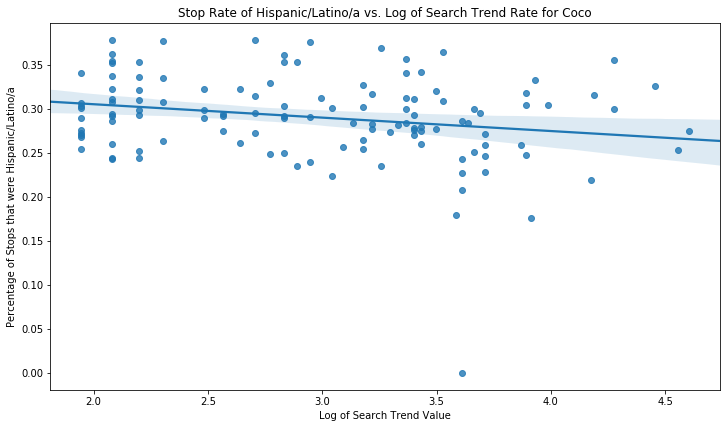

In [30]:
reg_coco = regression(('09-22-2017', '01-22-2018'), 'Hispanic/Latino/a', 'Coco', save_fig = True)
#eda_viz.month_race_count_viz(('09-22-2017', '01-22-2018'), 'Coco', save_fig = True)

<class 'matplotlib.axes._subplots.AxesSubplot'>


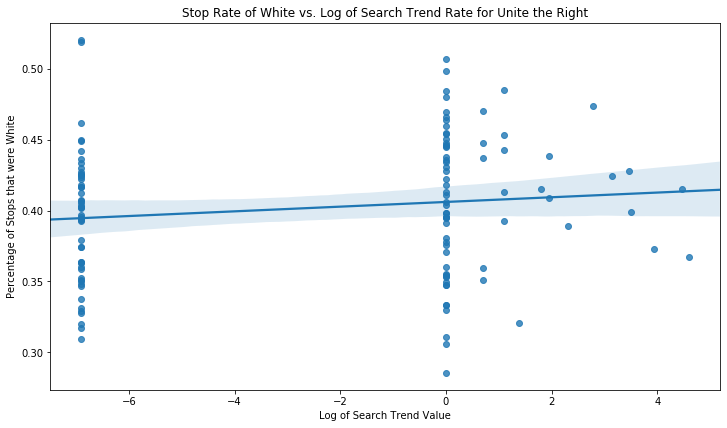

In [31]:
reg_utr = regression(('06-12-2017', '10-12-2017'), 'White', 'Unite the Right', save_fig = True)
#eda_viz.month_race_count_viz(('06-12-2017', '10-12-2017'), 'Unite the Right', save_fig = True)

<class 'matplotlib.axes._subplots.AxesSubplot'>


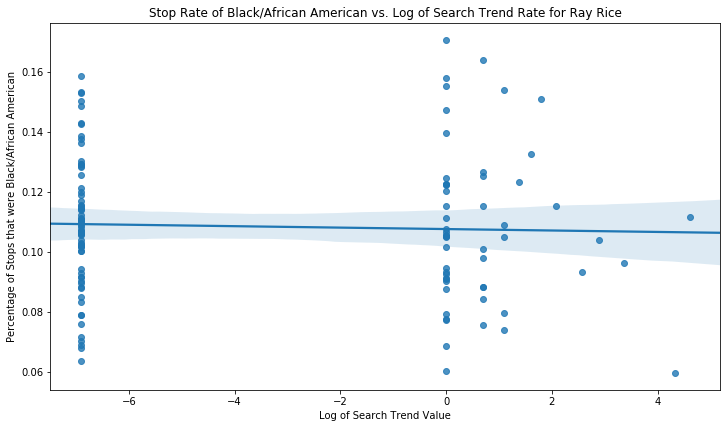

In [32]:
reg_rr = regression(('07-08-2014', '11-08-2014'), 'Black/African American', 'Ray Rice', save_fig = True)
#eda_viz.month_race_count_viz(('07-08-2014', '11-08-2014'), 'Ray Rice', save_fig = True)

<class 'matplotlib.axes._subplots.AxesSubplot'>


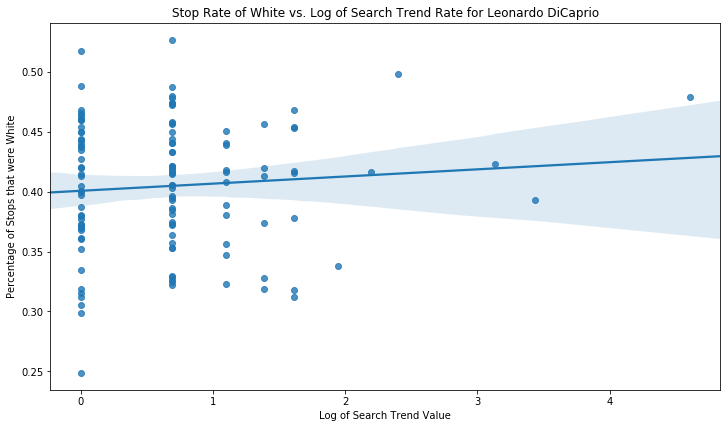

In [33]:
reg_ldc = regression(('12-28-2015', '04-28-2016'), 'White', 'Leonardo DiCaprio', save_fig = True)
#eda_viz.month_race_count_viz(('12-28-2015', '04-28-2016'), 'Leonardo DiCaprio', save_fig = True)

<class 'matplotlib.axes._subplots.AxesSubplot'>


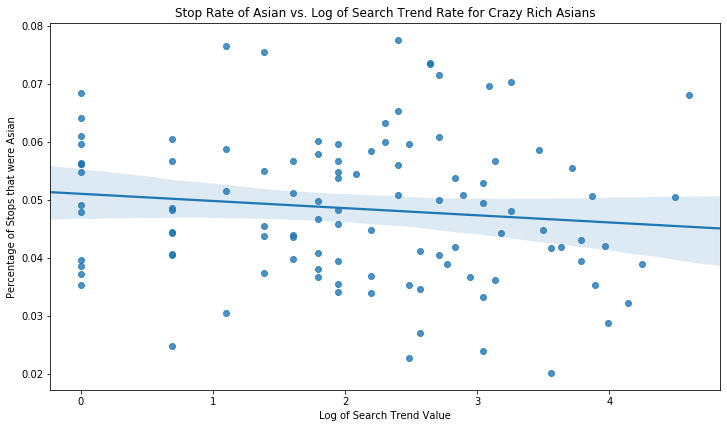

In [34]:
reg_cra = regression(('06-15-2018', '10-15-2018'), 'Asian', 'Crazy Rich Asians', save_fig = True)
#eda_viz.month_race_count_viz(('06-15-2018', '10-15-2018'), 'Crazy Rich Asians', save_fig = True)

<class 'matplotlib.axes._subplots.AxesSubplot'>


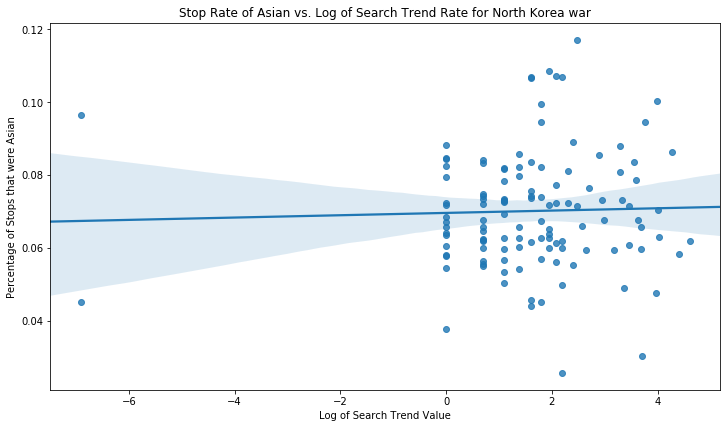

In [35]:
reg_nkw = regression(('02-01-2017', '06-01-2017'), 'Asian', 'North Korea war', save_fig = True)
#eda_viz.month_race_count_viz(('02-01-2017', '06-01-2017'), 'North Korea war', save_fig = True)